# MPG classification task
## In this lab I will develop a model to determine whether a given car will have a high or low gas mileage by exploring various classification models such as `logistic regression`, `linear discriminant analysis`, `Quadratic discriminant analysis`, `naive bayes`, and `K-nearest neighbors` to determine which model is most suitable for the task at hand.
## For this approach I first conduct a statistical-based feature selection for univariate and multivariate analysis.
### **1. Importing libraries and loading data**

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [148]:
auto = pd.read_csv('Auto.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [149]:
print('shape:', auto.shape)

shape: (392, 9)


### This data set consists of 392 cars and 8 predictors to determine the gas mileage.
### For this task we classify between high and low gas mileage by using the median as our threshold.

In [150]:
auto['mpg'].median()

22.75

In [151]:
# Creating classification class
auto['mpg_class'] = np.where(auto['mpg'] > auto['mpg'].median(), 1, 0)
auto.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_class
11,14.0,8,340.0,160,3609,8.0,70,1,plymouth 'cuda 340,0
197,20.0,6,225.0,100,3651,17.7,76,1,dodge aspen se,0
139,29.0,4,98.0,83,2219,16.5,74,2,audi fox,1
312,26.4,4,140.0,88,2870,18.1,80,1,ford fairmont,1
171,24.0,4,119.0,97,2545,17.0,75,3,datsun 710,1


### With a median gas mileage of 22.75, any value above the median is classified as high gas mileage (denoted as 1) and low gas mileage otherwise (denoted as 0).
### **2. Statistical analysis**
### For statistical significance I will determine the pearson correlation coefficient of each predictor to the target as pre-selection. This is followed by a univariate analysis to measure the p-value and t-statistic of the chosen features for further investigation of statistical significance.

In [152]:
# Class distribution
auto['mpg_class'].value_counts()

0    196
1    196
Name: mpg_class, dtype: int64

In [153]:
auto = auto.drop(columns= 'mpg')
corr = auto.corr()
corr['mpg_class'].sort_values(ascending= False)

C:\Users\Dolf\AppData\Local\Temp\ipykernel_25452\2199375211.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = auto.corr()


mpg_class       1.000000
origin          0.513698
year            0.429904
acceleration    0.346822
horsepower     -0.667053
displacement   -0.753477
weight         -0.757757
cylinders      -0.759194
Name: mpg_class, dtype: float64

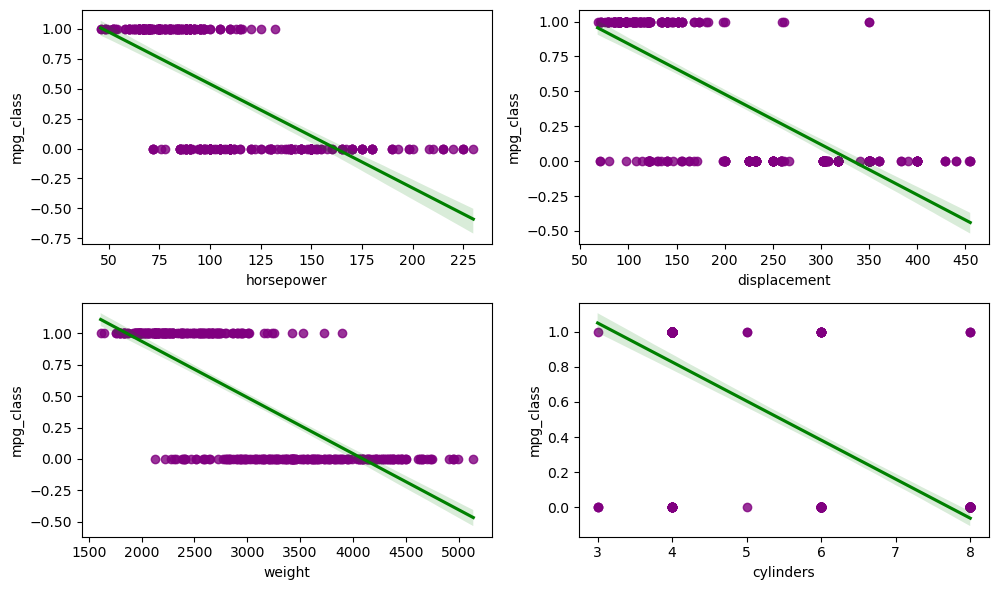

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# First subplot
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot
sns.regplot(y=auto['mpg_class'], x=auto['horsepower'], color='purple', line_kws={'color': 'green'})
plt.xlabel('horsepower')
plt.ylabel('mpg_class')

# Second subplot
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second subplot
sns.regplot(y=auto['mpg_class'], x=auto['displacement'], color='purple', line_kws={'color': 'green'})
plt.xlabel('displacement')
plt.ylabel('mpg_class')

# Third subplot
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third subplot
sns.regplot(y=auto['mpg_class'], x=auto['weight'], color='purple', line_kws={'color': 'green'})
plt.xlabel('weight')
plt.ylabel('mpg_class')

# Fourth subplot
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth subplot
sns.regplot(y=auto['mpg_class'], x=auto['cylinders'], color='purple', line_kws={'color': 'green'})
plt.xlabel('cylinders')
plt.ylabel('mpg_class')

plt.tight_layout()

### Using the correlation coefficients with a threshold of 0.6, we observe a negative relationship between the `horsepower`, `displacement`, `weight`, and `cylinders` with the `gas mileage`. These predictors are then used for a univariate analysis using a linear regression. In correlation analysis a negative coefficient is as useful as a positive coefficient.
### **Univariate analysis**

In [155]:
# Printing the table header with t-statistic and p-value
print('{:>} {:>22} {:>24}'.format('predictor', 't-statistic', 'pvalue'))

# Initialize an empty dictionary to store t-statistic values
t_statistics = {}
predictors = auto[['horsepower', 'displacement', 'weight', 'cylinders']]

# Loop through each predictor and perform a univariate linear regression
for predictor in predictors:
    X = MS([predictor]).fit_transform(auto)
    y = auto['mpg_class']
    model = sm.OLS(y, X)
    rslt = model.fit()
    
    # Print the predictor name, t-statistic, and p-value
    print('{:>9} {:>22} {:>24.2f}'.format(predictor, rslt.tvalues[predictor], rslt.pvalues[predictor]))
    
    # Store the t-statistic value for the predictor in the 't_statistics' dictionary
    t_statistics[predictor] = [rslt.tvalues[predictor]]

predictor            t-statistic                   pvalue
horsepower     -17.68193936887461                     0.00
displacement    -22.632003549122086                     0.00
   weight    -22.932776972525126                     0.00
cylinders    -23.035327865818914                     0.00


### All 4 predictors appear to be statistically significant. The negative t-statistic is indicative of the negative slope/relationship, and the predictors have a p-value less than 0.05 therefore we can reject the null hypotheses (which states that there is no relationship between the predictors and the target).
### I will then conduct a multivariate analysis using a multiple linear regression to determine if there is any association between the predictors.
### **Multivariate analysis**

In [156]:
X = MS(predictors).fit_transform(auto)
model = sm.OLS(y, X)
rslt = model.fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mpg_class   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     149.8
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           2.80e-77
Time:                        23:46:00   Log-Likelihood:                -101.13
No. Observations:                 392   AIC:                             212.3
Df Residuals:                     387   BIC:                             232.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.8033      0.113     15.965      0.000       1.581       2.025
horsepower       0.0011      0.001      1.132      0.258      -0.001       0.003
displacement    -0.0004      0.001     -0.524      0.600      -0.002       0.001
weight          -0.0002   5.33e-05     -4.526      0.000      -0.000      -0.000
cylinders       -0.1152      0.030     -3.787      0.000      -0.175      -0.055
==============================================================================
Omnibus:                       44.674   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.234
Skew:                          -0.771   Prob(JB):                     1.13e-14
Kurtosis:                       4.246   Cond. No.                     2.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The multivariate linear regression has an F-statistic of 149.8 and an R-sqaured of 0.608, that is to say 60.8% of changes in mpg can be explained by the combination of these predictors (this can be simplified by thinking of the model as being 60.8% accurate).
### We do however note that `horsepower` and `displacement` have increased p-values which is higher than 0.05,  therefore we can not reject the null hypothesis for this predictors. 
### Removing these two predictors from the model increases the F-statistic to  299.6, this is a considerable increase and suggests that the smaller model is more statistically significant. This however decreases the R-sqaured to 60.6% which is an insignificant decrease for a more effecient model.
### **3. Classification algorithms**
### I will test various classification models to determine which algorithm is most suitable in predicting whether a certain car will have high or low gas milage using `weight` and `cylinders` as the only predictors.
### I will seperate the data into training and test set to test which algortithm performs the best on unseen data. This will be measured by the accuracy score.

In [157]:
X = auto[['weight', 'cylinders']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0)

# Linear discriminant analysis
lda = LDA()
lda = lda.fit(X_train, y_train)

# Confusion matrix
lda_pred = lda.predict(X_test)
lda_cm = confusion_matrix(y_test, lda_pred)
lda_accuracy = accuracy_score(y_test, lda_pred)

print('Confusion matrix:')
print(lda_cm , '\n')
print('Accuracy: {:.2f}'.format(lda_accuracy * 100)) 

Confusion matrix:
[[39  9]
 [ 6 44]] 

Accuracy: 84.69


In [158]:
# Logistic regression analysis
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

# Confusion matrix
logreg_pred = logreg.predict(X_test)
logreg_cm = confusion_matrix(y_test, logreg_pred)
logreg_accuracy = accuracy_score(y_test, logreg_pred)

print('Confusion matrix:')
print(logreg_cm , '\n')
print('Accuracy: {:.2f}'.format(logreg_accuracy * 100)) 

Confusion matrix:
[[39  9]
 [ 7 43]] 

Accuracy: 83.67


In [159]:
# Quadratic discriminant analysis
qda = QDA()
qda = qda.fit(X_train, y_train)

# Confusion matrix
qda_pred = qda.predict(X_test)
qda_cm = confusion_matrix(y_test, qda_pred)
qda_accuracy = accuracy_score(y_test, qda_pred)

print('Confusion matrix:')
print(qda_cm , '\n')
print('Accuracy: {:.2f}'.format(qda_accuracy * 100)) 

Confusion matrix:
[[39  9]
 [ 7 43]] 

Accuracy: 83.67


In [160]:
# Naive bayes
nb = GaussianNB()
nb = nb.fit(X_train, y_train)

# Confusion matrix
nb_pred = nb.predict(X_test)
nb_cm = confusion_matrix(y_test, nb_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)

print('Confusion matrix:')
print(nb_cm , '\n')
print('Accuracy: {:.2f}'.format(nb_accuracy * 100)) 

Confusion matrix:
[[39  9]
 [ 6 44]] 

Accuracy: 84.69


In [161]:
# Searching for the optimal value of K
neighbors = []
for n in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors= n)
    knn = knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    neighbors.append(knn_accuracy)
    print('Accuracy: {:.2f}'.format(knn_accuracy * 100))
best_n = max(neighbors)
best_n = neighbors.index(best_n) + 1
print(' ')
print('Best k:', best_n)

# Optimal K-nearest neighbour
knn = KNeighborsClassifier(n_neighbors= best_n)
knn = knn.fit(X_train, y_train)

# Confusion matrix
knn_pred = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)

print(' ')
print('Confusion matrix:')
print(knn_cm , '\n')
print('Accuracy: {:.2f}'.format(knn_accuracy * 100)) 


Accuracy: 77.55
Accuracy: 80.61
Accuracy: 81.63
Accuracy: 84.69
Accuracy: 83.67
Accuracy: 83.67
Accuracy: 84.69
Accuracy: 83.67
Accuracy: 81.63
 
Best k: 4
 
Confusion matrix:
[[41  7]
 [ 8 42]] 

Accuracy: 84.69


### **Conclusion**
### We achieve the highest accuracy using the `linear discriminant analysis`, `naive bayes`, and `K-nearest neighbors with k = 4` all attaining 84.69% accuracy. 
### Since we want to optimise on fuel efficient cars, we can use the results of the confusion matrix for each of these models. The focus should be on true positives, the number of vehicles predicted as having high gas mileage. We observe that the `linear discriminant analysis` and `naive bayes` correctly classify 44 cars having high mpg while the `K-nearest neighbors` only classifies 42 correctly.
### This makes intuitive sense since this problem is fairly linear, `linear discriminant analysis` is suitable for linear problems with even class sizes.
### **5. Model deployment**

In [162]:
# Linear discriminant analysis
lda = LDA()
lda = lda.fit(X, y)